In [1]:
import pandas as pd


# 1. Load EmpatheticDialogues
def load_empathetic(
    path: str = "/home/jocelynstrmec/CSC525/portfolio_project/mental_health_retrieval_chatbot/resources/empatheticdialogues/train.csv",
):
    df = pd.read_csv(path, quoting=1, on_bad_lines="skip")
    df["text"] = df["prompt"] + " " + df["utterance"]
    return df[["text"]]


# 2. Load DailyDialog
def load_dailydialog(
    path: str = "/home/jocelynstrmec/CSC525/portfolio_project/mental_health_retrieval_chatbot/resources/dailydialog/dialogues_text.txt",
):
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    conversations = [line.strip().replace("__eou__", "") for line in lines]
    df = pd.DataFrame(conversations, columns=["text"])
    return df


# Load datasets
empathic_df = load_empathetic()
daily_df = load_dailydialog()
combined_df = pd.concat([empathic_df, daily_df], ignore_index=True)

In [2]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import string


def eda_on_text_column(df, text_col="text", top_n_words=20, show_wordcloud=True):
    if text_col not in df.columns:
        raise ValueError(f"Column '{text_col}' not found in DataFrame.")

    print(f"🔍 EDA on column: '{text_col}'\n")

    # Basic stats
    total_rows = len(df)
    nulls = df[text_col].isnull().sum()
    print(f"Total entries: {total_rows}")
    print(f"Null entries: {nulls}")

    # Drop nulls for the rest of the analysis
    df = df.dropna(subset=[text_col])

    # Clean and tokenize
    def clean_text(text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
        return text.split()

    df["tokens"] = df[text_col].apply(clean_text)
    df["text_length"] = df["tokens"].apply(len)

    # Text length stats
    print("\n📏 Text Length Statistics (in tokens):")
    print(df["text_length"].describe())

    # Plot distribution
    sns.histplot(df["text_length"], bins=30, kde=True)
    plt.title("Distribution of Text Lengths")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.show()

    # Most common words
    all_tokens = [token for tokens in df["tokens"] for token in tokens]
    word_counts = Counter(all_tokens)
    most_common = word_counts.most_common(top_n_words)

    print(f"\n🗣️ Top {top_n_words} Most Common Words:")
    for word, count in most_common:
        print(f"{word}: {count}")

    # Bar plot of common words
    words, counts = zip(*most_common)
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f"Top {top_n_words} Words")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()

    # Wordcloud
    if show_wordcloud:
        wordcloud = WordCloud(
            width=800, height=400, background_color="white"
        ).generate_from_frequencies(word_counts)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Word Cloud of Text")
        plt.show()

🔍 EDA on column: 'text'

Total entries: 89786
Null entries: 0

📏 Text Length Statistics (in tokens):
count    89786.000000
mean        42.132248
std        148.887193
min          2.000000
25%         22.000000
50%         30.000000
75%         43.000000
max      17650.000000
Name: text_length, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


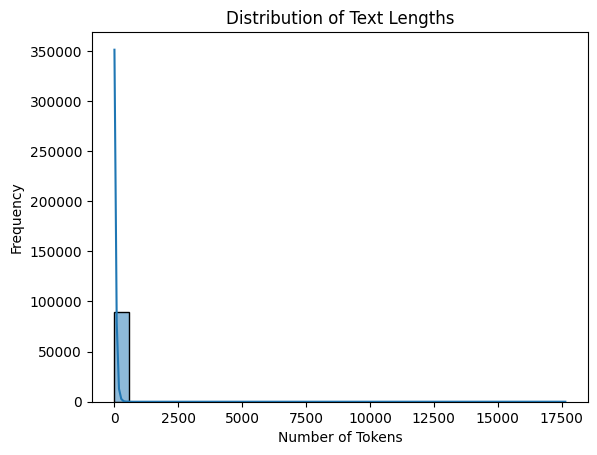


🗣️ Top 30 Most Common Words:
i: 217240
to: 110815
the: 104488
a: 102284
my: 86773
you: 70840
and: 69898
it: 65117
was: 53425
of: 44096
that: 41981
for: 41730
in: 41725
is: 37819
have: 34101
so: 31953
me: 31945
on: 25005
with: 22044
am: 20752
do: 20393
be: 20371
at: 20237
but: 20168
when: 19687
are: 18984
im: 18172
this: 17924
what: 17163
just: 16465


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


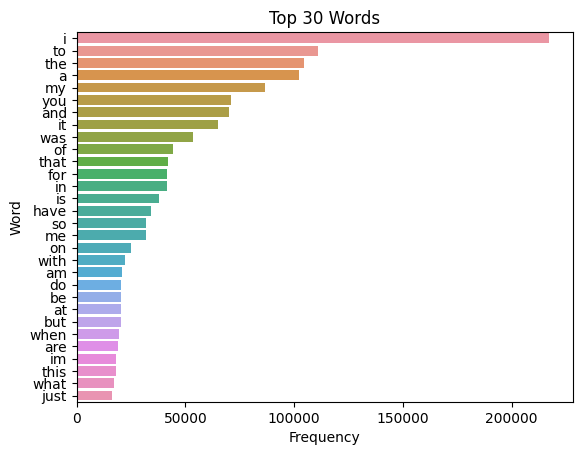

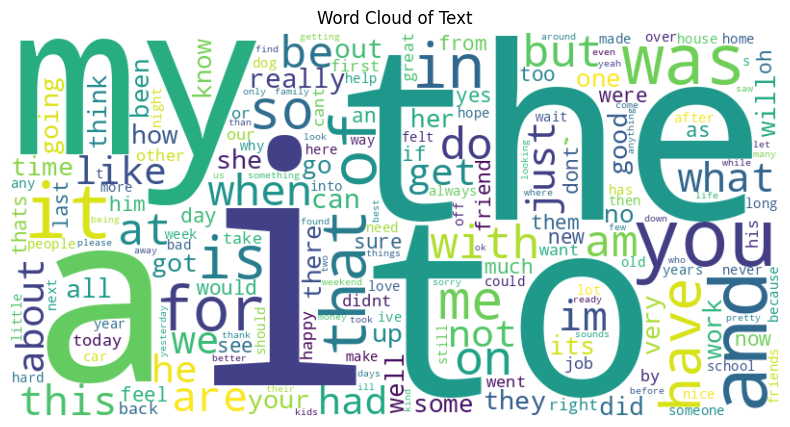

In [3]:
eda_on_text_column(combined_df, text_col="text", top_n_words=30, show_wordcloud=True)

In [4]:
combined_df.head()

,text
0,I remember going to the fireworks with my best...
1,I remember going to the fireworks with my best...
2,I remember going to the fireworks with my best...
3,I remember going to the fireworks with my best...
4,I remember going to the fireworks with my best...


In [5]:
combined_df.nunique()

text    88808
dtype: int64

In [6]:
len(combined_df)

89786

In [7]:
# remove duplicates
combined_df = combined_df.drop_duplicates(subset="text").reset_index(drop=True)

In [8]:
import pandas as pd

import pandas as pd
import json


def normalize(text):
    return re.sub(r"\s+", " ", text.strip().replace("_comma_", ","))


def parse_eou_dialog(line):
    """Split a __eou__-delimited string into a dialog list alternating user/bot."""
    turns = [normalize(t) for t in line.split("__eou__") if t.strip()]
    return {"dialog": turns} if len(turns) >= 2 else None


def load_and_parse_eou_block(df, text_col="text"):
    """Parse all rows in __eou__ format and return dialogs."""
    dialogs = []
    orphans = []
    for line in df[text_col]:
        if isinstance(line, str) and "__eou__" in line:
            parsed = parse_eou_dialog(line)
            if parsed:
                dialogs.append(parsed)
            else:
                orphans.append(line)
    return dialogs, orphans


def longest_common_prefix(texts):
    if not texts:
        return ""
    split_texts = [t.split() for t in texts]
    min_len = min(len(t) for t in split_texts)
    prefix = []
    for i in range(min_len):
        token = split_texts[0][i]
        if all(t[i] == token for t in split_texts):
            prefix.append(token)
        else:
            break
    return " ".join(prefix)


def group_by_lcp(df, text_col="text", threshold=2):
    # Normalize and preprocess
    df[text_col] = df[text_col].apply(normalize)

    used = set()
    groups = []
    orphan_rows = []

    for i, text in df[text_col].items():
        if i in used:
            continue
        # Try to find similar rows
        group = [i]
        for j, other in df[text_col].items():
            if i != j and j not in used:
                prefix = longest_common_prefix([text, other])
                if len(prefix.split()) >= threshold:
                    group.append(j)
        if len(group) > 1:
            used.update(group)
            groups.append(group)
        else:
            orphan_rows.append(text)

    return groups, orphan_rows


def build_conversations(df, groups, text_col="text"):
    conversations = []
    for group in groups:
        texts = df.loc[group, text_col].tolist()
        prefix = longest_common_prefix(texts)

        convo = []
        for i, text in enumerate(texts):
            if i == 0:
                utterance = text
            else:
                utterance = text[len(prefix) :].strip()
                if utterance.startswith("."):
                    utterance = utterance[1:].strip()
            speaker = "user" if i % 2 == 0 else "bot"
            convo.append({"speaker": speaker, "text": utterance})
        if len(convo) >= 2:
            conversations.append(convo)
    return conversations


def process_all_dialogs(eou, repeated, text_col="text"):
    # Separate __eou__ rows and regular rows
    df_eou = eou.copy()
    df_other = repeated.copy()

    # Handle __eou__ format
    eou_dialogs, eou_orphans = load_and_parse_eou_block(df_eou, text_col=text_col)

    # Handle multi-row group-by-prefix format
    groups, grouped_orphans = group_by_lcp(df_other, text_col=text_col, threshold=8)
    prefix_dialogs = build_conversations(df_other, groups, text_col=text_col)

    all_dialogs = eou_dialogs + prefix_dialogs
    all_orphans = eou_orphans + grouped_orphans

    return all_dialogs, all_orphans


def export_to_jsonl(dialogs, output_path):
    with open(output_path, "w", encoding="utf-8") as f:
        for d in dialogs:
            f.write(json.dumps(d, ensure_ascii=False) + "\n")
    print(f"✅ Exported {len(dialogs)} dialogs to {output_path}")

In [9]:
all_dialogs, all_orphans = process_all_dialogs(
    eou=daily_df, repeated=empathic_df, text_col="text"
)
export_to_jsonl(all_dialogs, "dialoGPT_ready.jsonl")
if all_orphans:
    print("⚠️ Orphan lines to review:")
    for line in all_orphans:
        print(line)

✅ Exported 15874 dialogs to dialoGPT_ready.jsonl
⚠️ Orphan lines to review:
i used to scare for darkness it feels like hitting to blank wall when i see the darkness
i used to scare for darkness Oh ya? I don't really see how
i used to scare for darkness dont you feel so.. its a wonder
i used to scare for darkness I do actually hit blank walls a lot of times but i get by
i used to scare for darkness i virtually thought so.. and i used to get sweatings
i used to scare for darkness Wait what are sweatings
I was home alone. I heard a loud noise come from the kitchen. The other night I was alone and heard a nose coming from the kitchen... it was creepy.
My friend called someone a bad name. My friend called someone a bad name, he really mad me upset.
My friend called someone a bad name. Oh god.. give it a few days and then try to sort it out!
I cant wait to relocate again. I cant wait to relocate and move again. I am so ready.
I cant wait to relocate again. Wow! Have you been to many places?


In [10]:
all_orphans

['i used to scare for darkness it feels like hitting to blank wall when i see the darkness',
 "i used to scare for darkness Oh ya? I don't really see how",
 'i used to scare for darkness dont you feel so.. its a wonder',
 'i used to scare for darkness I do actually hit blank walls a lot of times but i get by',
 'i used to scare for darkness i virtually thought so.. and i used to get sweatings',
 'i used to scare for darkness Wait what are sweatings',
 'I was home alone. I heard a loud noise come from the kitchen. The other night I was alone and heard a nose coming from the kitchen... it was creepy.',
 'My friend called someone a bad name. My friend called someone a bad name, he really mad me upset.',
 'My friend called someone a bad name. Oh god.. give it a few days and then try to sort it out!',
 'I cant wait to relocate again. I cant wait to relocate and move again. I am so ready.',
 'I cant wait to relocate again. Wow! Have you been to many places?',
 'I cant wait to relocate again.

In [11]:
len(all_orphans)

6586